# Example B — True Multimodal Learning: From Wind-Field Images to Language

## Purpose of this Notebook

This notebook demonstrates a **true multimodal learning setup**, in which a neural network generates **meteorological text descriptions directly from images** of wind fields over the **German Bight (North Sea)**.

In contrast to Example A, no symbolic or manually engineered summaries are used.  
All conditioning information is provided **exclusively through visual input**.

---

## Conceptual Shift from Example A

**Example A**  
- Physical wind fields  
- → symbolic spatial summaries  
- → language model  

**Example B (this notebook)**  
- Physical wind fields  
- → rendered images  
- → vision encoder  
- → language model  

This marks the transition from *symbolic proto-multimodality* to **visual grounding**.

---

## Multimodal Architecture Overview

The model consists of three main components:

1. **Vision Encoder (ViT)**  
   A pretrained Vision Transformer extracts a compact visual representation from each wind-field image.

2. **Vision–Language Bridge**  
   A lightweight, trainable linear layer maps visual embeddings into the embedding space of the language model.

3. **Language Model (T5)**  
   A pretrained text-generation model produces natural-language weather descriptions conditioned on the visual embedding.

Only the **bridge** and the **language model** are trained; the vision encoder remains frozen.

---

## Why This Example Is Deliberately Minimal

This setup is intentionally simplified in order to:

- isolate the **core multimodal learning mechanism**
- keep training stable on small synthetic datasets
- make failure modes (e.g. language priors, weak conditioning) visible and interpretable
- mirror real multimodal LLM architectures without unnecessary complexity

The focus is on **understanding**, not on maximizing performance.

---

## What to Look For

While working through this notebook, pay attention to:

- how visual structure influences generated language
- where the model succeeds in grounding text in images
- where it falls back to dominant linguistic priors
- how dataset balance and representation strength affect results

These behaviors are not flaws — they are **central insights** into multimodal learning.

---

## Take-Home Message

> *True multimodal models do not merely combine inputs — they must learn to balance perception and language.*

This notebook provides a transparent, hands-on demonstration of that principle.


In [1]:
import os

# DWD proxy
os.environ["HTTP_PROXY"]  = "http://ofsquid.dwd.de:8080"
os.environ["HTTPS_PROXY"] = "http://ofsquid.dwd.de:8080"

# Optional but recommended
os.environ["http_proxy"]  = os.environ["HTTP_PROXY"]
os.environ["https_proxy"] = os.environ["HTTPS_PROXY"]

In [2]:
import warnings

# Silence Hugging Face internal deprecation warnings
warnings.filterwarnings(
    "ignore",
    message=".*past_key_values.*"
)
warnings.filterwarnings(
    "ignore",
    category=FutureWarning
)

In [3]:
# Core
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import textwrap

# Torch
import torch
from torch import nn

# Vision + language
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    ViTModel
)

# Maps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Warnings (keep notebook clean)
import warnings
warnings.filterwarnings("ignore")

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [4]:
LON_MIN, LON_MAX = 6.0, 9.5
LAT_MIN, LAT_MAX = 53.0, 56.0
GRID_SIZE = 12

In [5]:
# ============================================================================
# Synthetic wind-field generator for the German Bight (North Sea)
#
# This function creates a physically plausible horizontal wind field on a
# regular latitude–longitude grid. It serves as the common data source for
# both Example A (symbolic encoding) and Example B (image-based multimodality).
#
# The design intentionally balances realism and simplicity:
# - Large-scale wind direction and speed are prescribed.
# - Small-scale spatial variability is added stochastically.
# - No vertical structure or dynamics are modeled.
# ============================================================================

def generate_wind_field(
    grid_size=GRID_SIZE,
    base_dir=315,
    base_speed=15.0,
    dir_variation=10.0,
    speed_variation=0.15,
):
    """
    Generate a synthetic 2D wind field over the German Bight.

    Parameters
    ----------
    grid_size : int
        Number of grid points in both longitude and latitude directions.
    base_dir : float
        Mean large-scale wind direction in degrees (meteorological convention).
    base_speed : float
        Mean large-scale wind speed in m/s.
    dir_variation : float
        Maximum local directional deviation (± degrees) applied per grid point.
    speed_variation : float
        Relative standard deviation of wind speed (fraction of base_speed).

    Returns
    -------
    LON : np.ndarray
        2D array of longitudes.
    LAT : np.ndarray
        2D array of latitudes.
    U : np.ndarray
        Zonal wind component (east–west) in m/s.
    V : np.ndarray
        Meridional wind component (north–south) in m/s.
    speed : np.ndarray
        Wind speed magnitude in m/s.
    theta : np.ndarray
        Local wind direction in degrees (meteorological convention).
    """

    # ------------------------------------------------------------------------
    # 1. Define the horizontal grid over the German Bight
    # ------------------------------------------------------------------------
    lon = np.linspace(LON_MIN, LON_MAX, grid_size)
    lat = np.linspace(LAT_MIN, LAT_MAX, grid_size)
    LON, LAT = np.meshgrid(lon, lat)

    # ------------------------------------------------------------------------
    # 2. Generate spatially varying wind directions
    # ------------------------------------------------------------------------
    # Apply random local deviations around the large-scale mean direction.
    # This mimics mesoscale variability while preserving a dominant flow.
    theta = base_dir + np.random.uniform(
        -dir_variation, dir_variation, size=(grid_size, grid_size)
    )

    # Convert to mathematical angle for vector decomposition
    theta_rad = np.deg2rad(270 - theta)

    # ------------------------------------------------------------------------
    # 3. Generate spatially varying wind speeds
    # ------------------------------------------------------------------------
    # Wind speed varies around the large-scale mean with a prescribed spread.
    speed = np.clip(
        np.random.normal(
            base_speed,
            base_speed * speed_variation,
            (grid_size, grid_size)
        ),
        0,
        40
    )

    # ------------------------------------------------------------------------
    # 4. Compute horizontal wind components
    # ------------------------------------------------------------------------
    U = speed * np.cos(theta_rad)  # zonal (east–west) component
    V = speed * np.sin(theta_rad)  # meridional (north–south) component

    return LON, LAT, U, V, speed, theta


In [6]:
def render_wind_image(LON, LAT, U, V):
    fig = plt.figure(figsize=(4, 4), dpi=100)
    ax = plt.axes(projection=ccrs.PlateCarree())

    ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX])
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")

    ax.quiver(LON, LAT, U, V, scale=350)
    ax.axis("off")

    # Draw the canvas
    fig.canvas.draw()

    # --- NEW, SAFE API ---
    buf = np.asarray(fig.canvas.buffer_rgba())
    image = buf[..., :3]   # drop alpha channel

    plt.close(fig)

    # Normalize to [0, 1]
    return image.astype(np.float32) / 255.0

In [7]:
def generate_reference_text(speed, theta):
    mean_speed = np.mean(speed)

    directions = {
        0: "northerly", 45: "northeasterly", 90: "easterly",
        135: "southeasterly", 180: "southerly",
        225: "southwesterly", 270: "westerly", 315: "northwesterly",
    }

    dirs = np.array(list(directions.keys()))
    mean_dir = np.mean(theta) % 360
    closest = dirs[np.argmin(np.abs(dirs - mean_dir))]

    approx = [5, 10, 15, 20, 25, 30]
    approx_speed = approx[np.argmin(np.abs(np.array(approx) - mean_speed))]

    return (
        f"{directions[closest].capitalize()} winds over the German Bight "
        f"with {('strong' if mean_speed > 12 else 'moderate')} "
        f"intensity and speeds around {approx_speed} m/s."
    )

In [8]:
# ============================================================================
# Build a multimodal training dataset (image → text)
#
# Each training sample consists of:
#   1. A synthetic wind field over the German Bight
#   2. A rendered image of this wind field (model input)
#   3. A natural-language weather description (training target)
#
# Important design choices:
# - Wind directions are sampled uniformly over all 8 main compass directions
#   to avoid directional bias in the dataset.
# - Wind speeds vary between 6 and 25 m/s to cover light to strong conditions.
# - The neural network never sees the numerical wind field, only the image.
# ============================================================================

images = []   # list of wind-field images (RGB arrays)
texts  = []   # list of corresponding weather descriptions

num_samples = 80

for _ in range(num_samples):

    # ------------------------------------------------------------------------
    # 1. Sample physically plausible large-scale conditions
    # ------------------------------------------------------------------------
    base_dir = random.choice([0, 45, 90, 135, 180, 225, 270, 315])  # degrees
    base_speed = random.uniform(6, 25)                             # m/s

    # ------------------------------------------------------------------------
    # 2. Generate a spatially varying wind field
    #    (local direction and speed variations are added internally)
    # ------------------------------------------------------------------------
    LON, LAT, U, V, speed, theta = generate_wind_field(
        base_dir=base_dir,
        base_speed=base_speed
    )

    # ------------------------------------------------------------------------
    # 3. Render the wind field as an image
    #    This image is the ONLY input seen by the multimodal model.
    # ------------------------------------------------------------------------
    img = render_wind_image(LON, LAT, U, V)

    # ------------------------------------------------------------------------
    # 4. Generate the reference text description
    #    This serves as the supervised learning target.
    # ------------------------------------------------------------------------
    txt = generate_reference_text(speed, theta)

    # ------------------------------------------------------------------------
    # 5. Store the multimodal pair
    # ------------------------------------------------------------------------
    images.append(img)
    texts.append(txt)


In [9]:
vit = ViTModel.from_pretrained("google/vit-base-patch16-224")
vit.eval()
vit.to(device)

for p in vit.parameters():
    p.requires_grad = False

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# ============================================================================
# Multimodal bridge: Vision encoder → Language model
#
# This module connects the visual representation produced by a Vision Transformer
# (ViT) with the text-generation backbone (T5).
#
# Key idea:
# - The vision encoder produces embeddings in a *vision-specific* feature space.
# - The language model expects embeddings in a *text-specific* feature space.
# - This module learns a linear projection between the two spaces.
#
# Importantly:
# - This is the ONLY trainable component that directly links vision and language.
# - All multimodal grounding capacity passes through this layer.
# ============================================================================

class VisionToText(nn.Module):
    def __init__(self, vit_dim=768, t5_dim=512):
        """
        Parameters
        ----------
        vit_dim : int
            Dimensionality of the ViT output embedding (e.g. 768 for ViT-base).
        t5_dim : int
            Dimensionality of the T5 encoder embedding space (512 for T5-small).
        """
        super().__init__()

        # Linear projection from vision embedding space to text embedding space
        self.proj = nn.Linear(vit_dim, t5_dim)

    def forward(self, x):
        """
        Forward pass.

        Parameters
        ----------
        x : torch.Tensor
            Visual embedding tensor of shape (batch_size, vit_dim),
            typically the CLS token output of the Vision Transformer.

        Returns
        -------
        torch.Tensor
            Projected embedding of shape (batch_size, t5_dim),
            compatible with the T5 text decoder.
        """
        return self.proj(x)


In [11]:
# ============================================================================
# Assemble the multimodal model and define the optimization strategy
#
# Components:
# 1. Text decoder: pretrained T5-small (language generation backbone)
# 2. Multimodal bridge: VisionToText (learned vision → language projection)
#
# Training strategy:
# - The Vision Transformer (ViT) is frozen (see previous cell).
# - The bridge AND the T5 decoder are trainable.
# - The model learns to generate text conditioned on visual embeddings.
# ============================================================================

# --- Tokenizer for text generation ---
# Converts target weather descriptions into token IDs
tokenizer = T5Tokenizer.from_pretrained(
    "t5-small",
    legacy=True   # explicit for stable, reproducible behavior
)

# --- Text generation backbone ---
# Pretrained encoder–decoder Transformer for conditional text generation
t5 = T5ForConditionalGeneration.from_pretrained(
    "t5-small"
).to(device)

# --- Multimodal bridge ---
# Projects visual embeddings into the T5 embedding space
bridge = VisionToText().to(device)

# --- Optimizer ---
# We optimize ONLY:
#   - the multimodal bridge (vision → text)
#   - the T5 language model parameters
#
# The vision encoder itself remains frozen.
optimizer = torch.optim.AdamW(
    list(bridge.parameters()) + list(t5.parameters()),
    lr=5e-5
)

In [12]:
# ============================================================================
# Multimodal training loop: image → text generation
#
# This cell performs the actual multimodal learning.
#
# High-level workflow for each training sample:
#   1. Convert a rendered wind-field image into a tensor
#   2. Extract a visual embedding using a frozen Vision Transformer (ViT)
#   3. Project the visual embedding into the T5 embedding space
#   4. Generate text conditioned on the visual embedding
#   5. Compute cross-entropy loss and update trainable parameters
#
# IMPORTANT:
# - The model never sees numerical wind values or symbolic summaries.
# - All information about the wind field enters ONLY through the image.
# ============================================================================

def preprocess_image(img):
    """
    Prepare an RGB image for the Vision Transformer.

    Parameters
    ----------
    img : np.ndarray
        Image array of shape (H, W, 3) with values in [0, 1].

    Returns
    -------
    torch.Tensor
        Tensor of shape (1, 3, 224, 224) suitable for ViT input.
    """
    img = torch.tensor(img).permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)
    img = nn.functional.interpolate(img, size=(224, 224)) # ViT input size
    return img.to(device)


num_epochs = 12

for epoch in range(num_epochs):
    loss_sum = 0.0

    # ------------------------------------------------------------------------
    # Loop over all multimodal training samples
    # ------------------------------------------------------------------------
    for img, txt in zip(images, texts):

        # ------------------------------------------------------------
        # 1. Image preprocessing
        # ------------------------------------------------------------
        pixel_values = preprocess_image(img)

        # ------------------------------------------------------------
        # 2. Visual feature extraction (frozen ViT)
        # ------------------------------------------------------------
        # We disable gradient computation here because the vision
        # encoder is frozen and should not be updated.
        with torch.no_grad():
            vision_out = vit(pixel_values=pixel_values)

            # Use the CLS token as a global image representation
            vision_feat = vision_out.last_hidden_state[:, 0, :]  # (1, 768)

        # ------------------------------------------------------------
        # 3. Vision → text projection
        # ------------------------------------------------------------
        # Project the visual embedding into the T5 embedding space
        # and add a sequence dimension expected by the T5 encoder.
        encoder_embed = bridge(vision_feat).unsqueeze(1)  # (1, 1, 512)

        # ------------------------------------------------------------
        # 4. Prepare target text tokens
        # ------------------------------------------------------------
        labels = tokenizer.encode(
            txt,
            return_tensors="pt",
            max_length=64,
            truncation=True
        ).to(device)

        # ------------------------------------------------------------
        # 5. Conditional text generation + loss computation
        # ------------------------------------------------------------
        # The T5 model is conditioned directly on the visual embedding
        # via inputs_embeds (no text input on the encoder side).
        outputs = t5(
            inputs_embeds=encoder_embed,
            labels=labels
        )

        loss = outputs.loss

        # ------------------------------------------------------------
        # 6. Backpropagation and parameter update
        # ------------------------------------------------------------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

    # ------------------------------------------------------------------------
    # Epoch summary
    # ------------------------------------------------------------------------
    avg_loss = loss_sum / len(texts)
    print(f"Epoch {epoch+1:02d}/{num_epochs} | Mean loss: {avg_loss:.4f}")


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 01/12 | Mean loss: 3.4440
Epoch 02/12 | Mean loss: 0.3505
Epoch 03/12 | Mean loss: 0.2063
Epoch 04/12 | Mean loss: 0.1479
Epoch 05/12 | Mean loss: 0.1113
Epoch 06/12 | Mean loss: 0.0890
Epoch 07/12 | Mean loss: 0.0757
Epoch 08/12 | Mean loss: 0.0653
Epoch 09/12 | Mean loss: 0.0561
Epoch 10/12 | Mean loss: 0.0494
Epoch 11/12 | Mean loss: 0.0449
Epoch 12/12 | Mean loss: 0.0418


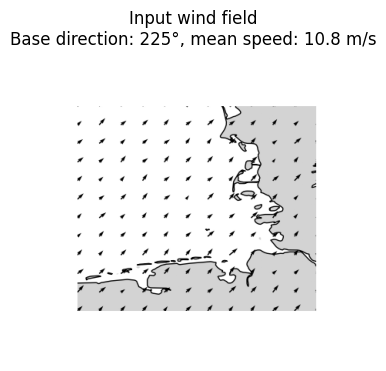

Southwesterly winds over the German Bight with moderate intensity and
speeds around 10 m/s.
------------------------------------------------------------


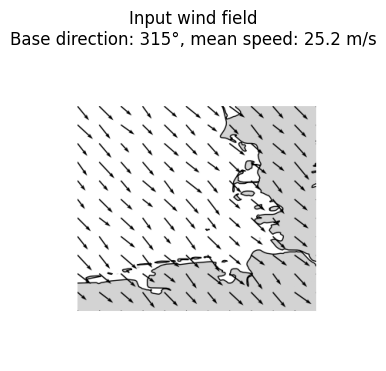

Northwesterly winds over the German Bight with strong intensity and
speeds around 20 m/s.
------------------------------------------------------------


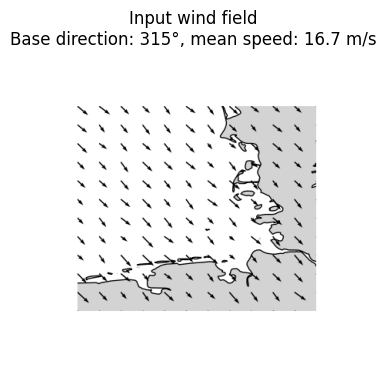

Northwesterly winds over the German Bight with strong intensity and
speeds around 15 m/s.
------------------------------------------------------------


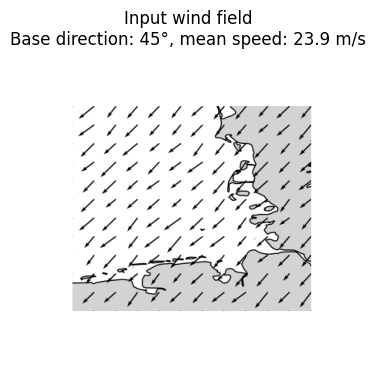

Northeasterly winds over the German Bight with strong intensity and
speeds around 25 m/s.
------------------------------------------------------------


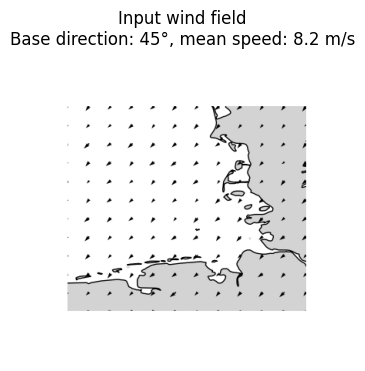

Southeasterly winds over the German Bight with moderate intensity and
speeds around 10 m/s.
------------------------------------------------------------


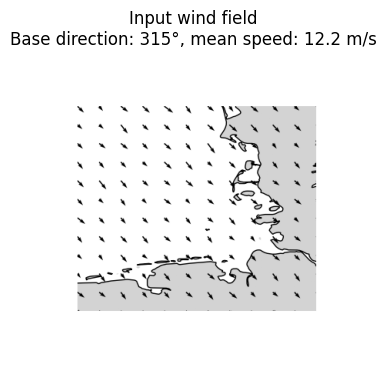

Southwesterly winds over the German Bight with moderate intensity and
speeds around 10 m/s.
------------------------------------------------------------


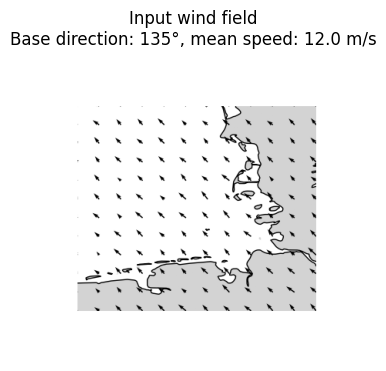

Southeasterly winds over the German Bight with moderate intensity and
speeds around 10 m/s.
------------------------------------------------------------


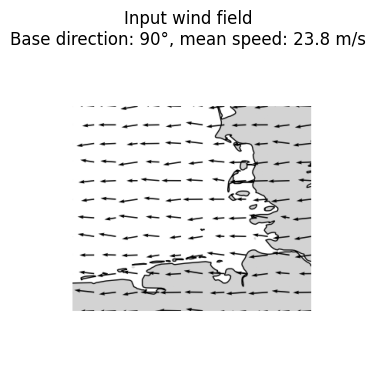

Easterly winds over the German Bight with strong intensity and speeds
around 25 m/s.
------------------------------------------------------------


In [14]:
# ============================================================================
# Run inference on unseen wind fields with physical reference diagnostics
#
# In addition to the generated text, we display:
# - the prescribed large-scale wind direction
# - the average wind speed of the generated field
#
# This allows direct comparison between:
#   physical input  ↔  visual impression  ↔  generated language
# ============================================================================
def generate_from_image(img):
    """
    Generate a weather description from a wind-field image.

    Parameters
    ----------
    img : np.ndarray
        RGB image array of shape (H, W, 3), values in [0, 1].

    Returns
    -------
    str
        Generated natural-language weather description.
    """
    # ------------------------------------------------------------
    # 1. Preprocess image for the vision encoder
    # ------------------------------------------------------------
    pixel_values = preprocess_image(img)

    # ------------------------------------------------------------
    # 2. Extract visual features and generate text (no gradients)
    # ------------------------------------------------------------
    with torch.no_grad():
        vision_out = vit(pixel_values=pixel_values)

        # Use CLS token as global visual representation
        vision_feat = vision_out.last_hidden_state[:, 0, :]

        # Project visual embedding into T5 embedding space
        encoder_embed = bridge(vision_feat).unsqueeze(1)

        # Generate text conditioned on visual embedding
        output_ids = t5.generate(
            inputs_embeds=encoder_embed,
            max_length=60
        )

    # Decode token IDs to human-readable text
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)


num_examples = 8

for i in range(num_examples):

    # ------------------------------------------------------------------------
    # 1. Select a test wind direction (uniform over compass directions)
    # ------------------------------------------------------------------------
    base_dir = random.choice(
        [0, 45, 90, 135, 180, 225, 270, 315]
    )  # degrees
    base_speed = random.uniform(6, 25)                             

    # ------------------------------------------------------------------------
    # 2. Generate a new synthetic wind field
    # ------------------------------------------------------------------------
    LON, LAT, U, V, speed, theta = generate_wind_field(
        base_dir=base_dir, base_speed=base_speed
    )

    # Physical reference value (not shown to the model)
    mean_speed = np.mean(speed)

    # ------------------------------------------------------------------------
    # 3. Render wind field to image (model input)
    # ------------------------------------------------------------------------
    img = render_wind_image(LON, LAT, U, V)

    plt.figure(figsize=(4, 4))
    plt.imshow(img, origin="upper")
    plt.title(
        f"Input wind field\n"
        f"Base direction: {base_dir}°, mean speed: {mean_speed:.1f} m/s"
    )
    plt.axis("off")
    plt.show()

    # ------------------------------------------------------------------------
    # 4. Generate and display model output
    # ------------------------------------------------------------------------
    generated_text = generate_from_image(img)
    print(textwrap.fill(generated_text, 70))
    print("-" * 60)
